# Chapter 5: 

# Asymmetric Misclassifcation Costs và Tinh Chỉnh Tham Số

Trong chương 3 chúng ta đã khảo sát một số tiêu chí đánh giá chất lượng mô hình phân loại và chúng ta biết rằng với mỗi một tình huống thì lựa chọn một tiêu chí để đánh giá và lựa chọn mô hình phù hợp là quan trọng. Ví dụ với đòi hỏi xây dựng mô hình xác định các giao dịch tài chính gian lận thì Accuracy và thậm chí là cả tiêu chuẩn ROC/AUC là hoàn toàn không phù hợp khi dữ liệu là mất cân bằng. Trong tình huống này chúng ta phải chọn một tiêu chí thích hợp hơn như Recall - tức đo lường khả năng xác định đúng bao nhiêu phần trăm giao dịch là gian lận trong tổng số các cases gian lận thực sự. 


Tương tự là tình huống **bất cân bằng về chi phí khi phân loại sai** (Asymmetric Misclassifcation Costs) - một vấn đề rất phổ biến khi sử dụng các mô hình ML cho bài toán phân loại. Nói cách khác, cái giá phải trả cho việc phân loại sai tạo ra những hậu quả khác nhau nếu chúng ta sử dụng mô hình đó. Hãy lấy một ví dụ, giả sử chúng ta đang sử dụng mô hình X để phân loại một bệnh nhân bị hay không bị nhiễm HIV dựa trên các kết quả xét nghiệm sinh hóa của họ. Rõ ràng việc phân loại sai "một bệnh nhân thực sự bị HIV thành không nhiễm HIV" sẽ gây hậu quả lớn hơn nhiều khi phân loại sai "một bệnh nhân không nhiễm HIV thành bị nhiễm HIV". 

Tương tự như vậy, với một tổ chức tài chính như ngân hàng thương mại thì hậu quả của việc phân loại sai "khách hàng thực sự tốt được phân loại thành xấu" sẽ chỉ là việc mất đi cơ hội kiếm được phần trăm lãi ứng với khoản vay được đề nghị của khách hàng đó nhưng nếu phân loại sai "khách hàng là xấu nhưng được phân loại thành tốt" thì ngân hàng gần như mất trắng khoản tiền đã cho vay. 

Những phân tích trên, trong bối cảnh bài toán phân loại và xếp hạng tín dụng dẫn đến hệ quả là: 

- Hệ quả 1: Mô hình X có Accuracy (hoặc là AUC/ROC) cao hơn mô hình Y có thể lại là mô hình gây ra lỗ nhiều hơn cho ngân hàng. 
- Do tồn tại hệ quả 1 nên dẫn đến hệ quả 2 như sau: tiêu chí để so sánh, đánh giá và lựa chọn mô hình phân loại cần căn cứ vào tác động kinh tế (tức lãi - lỗ bao nhiêu) của việc sử dụng mô hình. 

Trong chương 2 chúng ta đã biết cách thức tinh chỉnh tham số tối ưu cho các mô hình ML dựa trên một tiêu chí nào đó. Tiêu chí đó thường là ROC/AUC cho bài toán phân loại nhị phân (tức biến Y chỉ có hai nhãn - hai giá trị). Tiêu chí đó cũng có thể là Recall (hoặc rất nhiều tiêu chí khác chúng ta có thể chọn trong menu sẵn có của thư viện Scikit Learn). Tuy nhiên việc tinh chỉnh tham số, so sánh và lựa chọn mô hình căn cứ vào tiêu chuẩn lợi nhuận thì lại không được giải quyết. 

Chương này hướng dẫn thực hành nhă đưa ra kết quả thực nghiệm để trả lời các câu hỏi sau: 

- Với các tiêu chí tinh chỉnh mô hình khác nhau thì tác động sẽ như thế nào đến lợi nhuận? 
- Do có sự đánh đổi giữa các tiêu chí khi ngưỡng được lựa chọn cho phân loại thay đổi thì lợi nhuận thay đổi ra sao? 

Việc làm rõ các câu hỏi trên sẽ là căn cứ để chúng ta xây dựng và lựa chọn một mô hình tốt nhất để thỏa mãn đòi hỏi của hầu hết các tổ chức vì lợi nhuận: lợi nhuận cao nhất có thể. Với **các tổ chức kinh doanh vì lợi nhuận thì tiêu chuẩn đầu tiên mà chúng quan tâm là lợi nhuận (Profit) chứ không phải các tiêu chí ưa thích của những người làm mô hình nói chung và người làm thống kê nói riêng là Accuracy, Recall hay ROC/AUC**. 

Về Asymmetric Misclassifcation Costs bạn đọc có thể cần tham khảo kĩ hơn ở trang 133 cuốn [Data Mining for Business Analytics: Concepts, Techniques, and Applications in R](https://www.dataminingbook.com/book/r-edition). Để minh họa chúng ta trở lại với bộ số liệu *UniversalBank.csv* được sử dụng nhiều lần trong textbook này:  

In [3]:
# Đọc dữ liệu: 
import pandas as pd
df_bank = pd.read_csv("C:/Users/Zbook/Desktop/DataMining/dmba/UniversalBank.csv")

#============================
#   Chuẩn bị dữ liệu 
#============================

# Bỏ biến không cần thiết: 
my_df_binary = df_bank.drop(["ZIP Code", "ID"], axis=1) 

# Tách ra features và target: 
Y = my_df_binary["Personal Loan"]
X = my_df_binary.drop("Personal Loan", 1)

# Phân chia dữ liệu theo tỉ lệ 60 - 40: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, 
                                                    random_state = 29, stratify = Y)

Thiết lập lưới tinh chỉnh tham số cho mô hình Random Forest (RF) như đã biết ở [chương 2](https://github.com/ChiDungNguyen/Chapter-2-Tinh_Chinh_Tham_So/blob/master/Chapter2_Turning_parameters(UniversalBank.csv).ipynb): 

In [4]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {"max_depth": [2, 3, None],
              "n_estimators": [500, 700, 1000],
              "max_features": [3, 5, 10],
              "min_samples_split": [3, 5, 10],
              "min_samples_leaf": [3, 5, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

Viết hàm tinh chỉnh tham số tối ưu cho RF theo tiêu chí được lựa chọn theo Random Search: 

In [5]:
# Hàm tinh chỉnh và huấn luyện RF theo một tiêu chí được chọn trước: 

from sklearn.model_selection import RandomizedSearchCV

def turning_RF(metric_selected):
    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=29),
                                   param_distributions=param_grid,
                                   cv=5,              
                                   n_iter=48,         
                                   scoring=metric_selected,
                                   n_jobs=-1,           
                                   random_state=29)

    rf_random.fit(X_train, y_train)
    return(rf_random) 

Thực hiện huấn luyện và tinh chỉnh các mô hình RF theo các tiêu chí là Accuracy, Recall và ROC/AUC đồng thời tính toán thời gian thực hiện: 

In [6]:
# Thực hiện tinh chỉnh RF theo các tiêu chí Accurracy, Recall và ROC/AUC và tính thời gian huấn luyện: 
import time
start_time=time.time()

rf_acc = turning_RF(metric_selected="accuracy")
rf_rec = turning_RF(metric_selected="recall")
rf_roc = turning_RF(metric_selected="roc_auc")

training_time = time.time() - start_time
print("Thời gian tinh chỉnh:", training_time)

Thời gian tinh chỉnh: 265.3802082538605


Kết quả là mất 265 giây để tinh chỉnh. Cấu hình máy tính khác nhau thì con số này sẽ khác và với cùng một máy tính thì con số này cũng khác. Dưới đây là kết quả cho thấy các tham số tốt nhất tương ứng với tiêu chí tinh chỉnh được chọn: 

In [7]:
# Giá trị tốt nhất của tham số tương ứng với một tiêu chí được chọn: 
print("Tham số tốt nhất với tiêu chí Accuracy:", rf_acc.best_params_)
print("Tham số tốt nhất với tiêu chí Recall:", rf_rec.best_params_)
print("Tham số tốt nhất với tiêu chí AUC/ROC:", rf_roc.best_params_)

Tham số tốt nhất với tiêu chí Accuracy: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Tham số tốt nhất với tiêu chí Recall: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Tham số tốt nhất với tiêu chí AUC/ROC: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}


Với các tiêu chuẩn được chọn để tinh chỉnh tham số khác nhau thì những giá trị tối ưu của tham số cũng khác như có thể thấy ở kết quả trên. Chúng ta sử dụng các mô hình RF với các tham số tối ưu tương ứng để thực hiện dự báo cho sự kiện "khách hàng đi vay là xấu" như sau: 

In [8]:
# Các mô hình RF tối ưu tương ứng với tiêu chí tinh chỉnh được chọn: 
best_rf_acc = rf_acc.best_estimator_
best_rf_rec = rf_rec.best_estimator_
best_rf_roc = rf_roc.best_estimator_

In [9]:
# Sử dụng các mô hình RF thực hiện dự báo: 
pred_acc = best_rf_acc.predict(X_test)
pred_rec = best_rf_rec.predict(X_test)
pred_roc = best_rf_roc.predict(X_test)

Chú ý rằng các nhãn 0 (tương ứng với khách hàng tốt) và 1 (tương ứng với khách hàng xấu) được dự báo dựa trên ước lượng về xác suất phá sản PD (Probability of Default) với ngưỡng (cutoff) mặc định là 0.5. 

# Biến đổi của Profit theo ngưỡng Cutoff được lựa chọn

Một khách hàng sẽ được phân loại là tốt hay xấu phụ thuộc vào hai yếu tố: (1) xác suất PD dự báo từ mô hình, và (2) ngưỡng cutoff được lựa chọn để phân loại khách hàng. Vấn đề này đã được giải thích trong chương 2. 

Giả sử rằng: (1) nếu được đồng ý cho vay bởi ngân hàng thì mỗi một khách hàng sẽ được giải ngân một khoản vay đúng bằng thu nhập của họ (thực tế các ngân hàng Việt Nam khi cấp tín dụng tiêu dùng, nếu khách hàng thỏa mãn thì họ sẽ được cấp một khoản vay thường là từ 1 đến 10 lần thu nhập sau thuế của họ tùy theo nhóm khách hàng), và (2) một khách hàng là xấu nhưng RF phân loại nhầm thành tốt thì ngân hàng sẽ mất trắng khoản vay. Dưới đây chúng ta viết hàm tình lãi thu về của ngân hàng với **rate** là lãi suất tính cho khoản vay: 

In [10]:
# Viết hàm tình lợi nhuận: 
import numpy as np

def calculate_profit(pred_by, rate):
    
    # Các khách hàng thực sự là tốt được phân loại đúng là tốt: 
    gg = X_test[(y_test == 0) & (pred_by == 0)]
    
    # Các kháng hàng là xấu nhưng phân loại sai thành tốt: 
    bg = X_test[(y_test == 1) & (pred_by == 0)]
    
    # Tính lợi nhuận: 
    profit = np.sum(rate*gg[["Income"]]) - np.sum(bg[["Income"]])
    
    return(profit)

Với lãi suất là 10% chẳng hạn thì lãi thu về của ngân hàng tương ứng với các mô hình RF lần lượt là: 

In [14]:
# Nếu RF được tinh chỉnh theo tiêu chí Accuracy: 
calculate_profit(pred_by=pred_acc, rate=0.10)

Income    10196.6
dtype: float64

In [15]:
# Nếu RF được tinh chỉnh theo tiêu chí Recall: 
calculate_profit(pred_by=pred_rec, rate=0.10)

Income    10419.7
dtype: float64

In [16]:
# Nếu RF được tinh chỉnh theo tiêu chí ROC/AUC" 
calculate_profit(pred_by=pred_roc, rate=0.10)

Income    9933.0
dtype: float64

Như vậy RF được tinh chỉnh theo tiêu chí Recall sẽ tạo ra nhiều lợi nhuận nhất cho ngân hàng. Tuy nhiên cần lưu ý là các kết quả này sử dụng ngưỡng mặc định 0.5 để phân loại khách hàng. Đê khảo sát lợi nhuận biến đổi ra sao khi ngưỡng này thay đổi trước hết chúng ta tính ra xác suất vỡ nợ PD (Probability of Default) của khách hàng rồi tính lợi nhuận tương ứng với một ngưỡng bất kì với mức lãi suất là 10%: 

In [17]:
# PD thu được từ RF tinh chỉnh theo tiêu chí Recall: 
pred_prob = best_rf_rec.predict_proba(X_test)

In [20]:
# Hàm tính lợi nhuận tương ứng với ngưỡng được chọn cho phân loại: 
def profit_by_cutoff(cutoff):
    
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int) 
    gg = X_test[(y_test == 0) & (pred_bg == 0)]
    bg = X_test[(y_test == 1) & (pred_bg == 0)]
    profit = np.sum(0.10*gg[["Income"]]) - np.sum(bg[["Income"]])
    
    return(profit)   

In [21]:
# Có thể kiểm tra rằng nếu cutoff bằng 0.5 sẽ có kết quả là 10419.7 như đã biết: 
profit_by_cutoff(cutoff=0.5)

Income    10419.7
dtype: float64

Viết vòng lặp tính toán lợi nhuận thu được tương ứng với các ngưỡng cutoff như sau: 

In [22]:
# Thiết lập một loạt ngưỡng của cutoff: 
cutoff = np.arange(0.025, 0.6, 0.025)

# Tạo ra array trống lưu dữ liệu: 
profit = []

# Viết vòng lặp for loop tính toán profit tương ứng với Cutoff được chọn: 
for i in cutoff:
    prof_i = profit_by_cutoff(cutoff=i)
    profit.append(prof_i) 

Kết quả cho thấy nếu sử dụng RF được tinh chỉnh theo Recall thì lợi nhuận lớn nhất sẽ là khoảng 10900 nếu ngưỡng lựa chọn để phân loại khách hàng là 0.10 (hình 1): 

Text(0.5, 1.0, 'Figure 1: Biến đổi của Profit khi Cutoff thay đổi (tinh chỉnh theo Recall)')

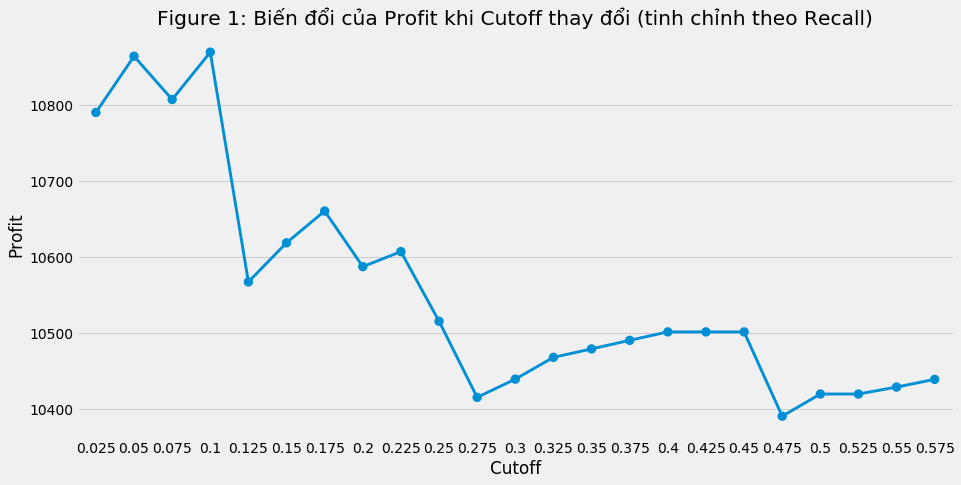

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Profit khi K thay đổi: 
plt.figure(figsize = (14, 7))
df_results_rec = {"Cutoff": np.round(cutoff, 4), "Profit": profit}
sns.pointplot(x="Cutoff", y="Profit", scale = 0.4, data = df_results_rec)
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 1: Biến đổi của Profit khi Cutoff thay đổi (tinh chỉnh theo Recall)")

Text(0.5, 1.0, 'Figure 2: Biến đổi của Profit khi Cutoff thay đổi (tinh chỉnh theo Accuracy)')

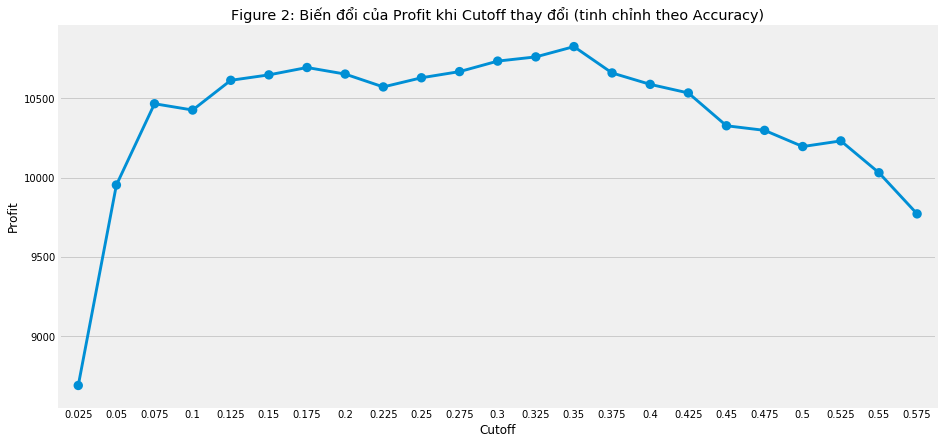

In [25]:
# Tương tự là khảo sát biến đổi của lợi nhuận khi cutoff thay đổi 
# cho mô hình RF được tinh chỉnh theo tiêu chí Accuracy: 

pred_prob = best_rf_acc.predict_proba(X_test)

def profit_by_cutoff(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int) 
    gg = X_test[(y_test == 0) & (pred_bg == 0)]
    bg = X_test[(y_test == 1) & (pred_bg == 0)]
    profit = np.sum(0.10*gg[["Income"]]) - np.sum(bg[["Income"]])
    return(profit) 


profit = []
for i in cutoff:
    prof_i = profit_by_cutoff(cutoff=i)
    profit.append(prof_i)
     
plt.figure(figsize = (14, 7))
df_results_acc = {"Cutoff": np.round(cutoff, 4), "Profit": profit}
sns.pointplot(x="Cutoff", y="Profit", scale = 0.4, data = df_results_acc)
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 2: Biến đổi của Profit khi Cutoff thay đổi (tinh chỉnh theo Accuracy)")

Text(0.5, 1.0, 'Figure 3: Biến đổi của Profit khi Cutoff thay đổi (tinh chỉnh theo ROC/AUC)')

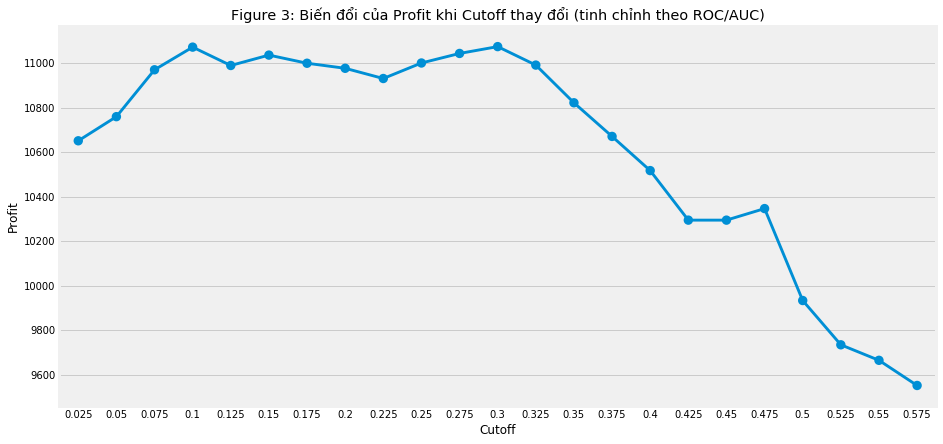

In [26]:
# Khảo sát biến đổi của lợi nhuận khi cutoff thay đổi 
# cho mô hình RF được tinh chỉnh theo tiêu chí ROC/AUC: 

pred_prob = best_rf_roc.predict_proba(X_test)

def profit_by_cutoff(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int) 
    gg = X_test[(y_test == 0) & (pred_bg == 0)]
    bg = X_test[(y_test == 1) & (pred_bg == 0)]
    profit = np.sum(0.10*gg[["Income"]]) - np.sum(bg[["Income"]])
    return(profit) 

profit = []
for i in cutoff:
    prof_i = profit_by_cutoff(cutoff=i)
    profit.append(prof_i)

plt.figure(figsize = (14, 7))
df_results_roc = {"Cutoff": np.round(cutoff, 4), "Profit": profit}
sns.pointplot(x="Cutoff", y="Profit", scale = 0.4, data = df_results_roc)
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 3: Biến đổi của Profit khi Cutoff thay đổi (tinh chỉnh theo ROC/AUC)")

Các kết quả trên cho thấy: **RF tinh chỉnh theo tiêu chí Accuracy tạo ra mức lợi nhuận cao nhất là  ở ngưỡng 0.35, RF tinh chỉnh theo tiêu chuẩn Recall tạo ra mức lợi nhuận cao nhất ở ngưỡng 0.1**. 

Câu hỏi ở đây là chúng ta sẽ kiến nghị ngân  hàng sử dụng RF nào? Sự lựa chọn cuối cùng lúc này cần căn cứ vào định hướng quản trị và một số yếu tố khác. Nêú là một tổ chức ưa thích an toàn và ổn định thì RF được tinh chỉnh theo ROC/AUC nên được lựa chọn vì lợi nhuận biến động nhỏ xung quanh ngưỡng 0.1 (tương ứng với mức tạo ra nhuận cao nhất) nhưng với mô hình RF được tinh chỉnh theo Recall thì lợi nhuận ở các mức xung quanh ngưỡng 0.1 biến động rất lớn. 

# Biến đổi của Accuracy theo ngưỡng Cutoff được lựa chọn

Python codes dưới đây cũng cho thấy rằng: 

- Thứ nhất, cùng một mô hình (chẳng hạn RF được tinh chỉnh theo Recall) thì ngưỡng đạt lợi nhuận cao nhất không trùng với ngưỡng đạt được Accuracy lớn nhất. 

- Thư hai, mô hình có Accuracy lớn nhất có thể lại lại mô hình tạo ra lợi nhuận kém hơn cho ngân hàng. Nguyên nhân là một mô hình có thể có Accuracy toàn cục (tức phân loại đúng cho cả khách hàng tốt lẫn xấu) cao nhưng nó cũng chính là mô hình mà phân loại nhầm "khách hàng xấu thành tốt" nhiều hơn. 

Text(0.5, 1.0, 'Figure 4: Biến đổi của Accuracy khi Cutoff thay đổi (tinh chỉnh theo Recall)')

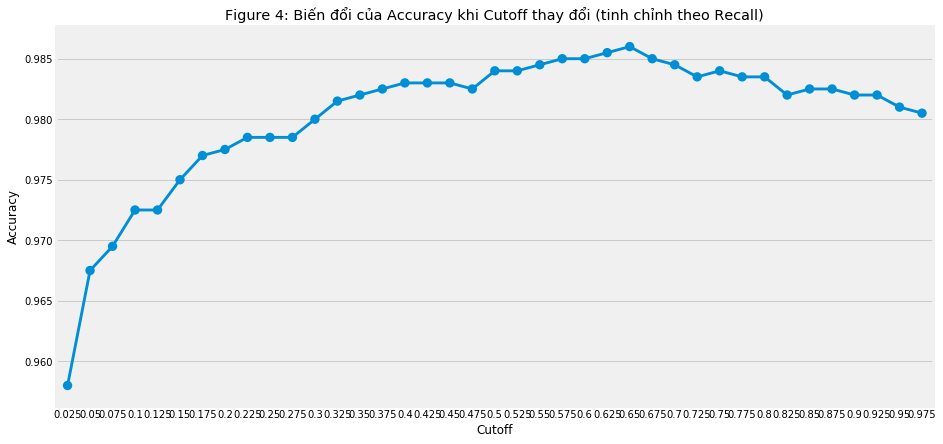

In [27]:
#============================================================================
#  Khảo sát sự biến đổi của Accuracy cho RF tinh chinh theo tiêu chí Recall
#============================================================================

pred_prob = best_rf_rec.predict_proba(X_test)

def calculate_accuracy(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int)
    accuracy = np.mean(pred_bg == y_test)
    return(accuracy)

cutoff = np.arange(0.025, 1, 0.025)

acc = []
for i in cutoff:
    acc_i = calculate_accuracy(cutoff=i)
    acc.append(acc_i)
    
plt.figure(figsize = (14, 7))
df_results_acc_by_rec = {"Cutoff": np.round(cutoff, 4), "Accuracy": acc}
sns.pointplot(x="Cutoff", y="Accuracy", scale = 0.4, data = df_results_acc_by_rec)
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")
plt.title("Figure 4: Biến đổi của Accuracy khi Cutoff thay đổi (tinh chỉnh theo Recall)")

Text(0.5, 1.0, 'Figure 5: Biến đổi của Accuracy khi Cutoff thay đổi (tinh chỉnh theo Accuracy)')

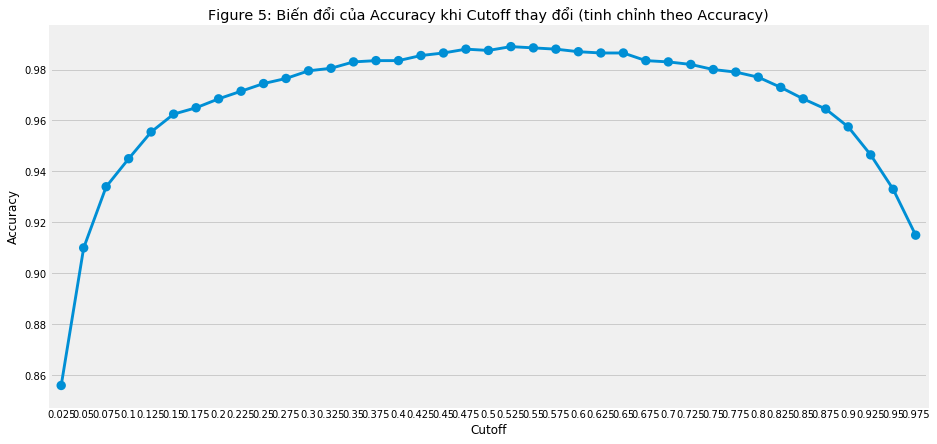

In [28]:
#============================================================================
#  Khảo sát sự biến đổi của Accuracy cho RF tinh chinh theo tiêu chí Accuracy
#============================================================================

pred_prob = best_rf_acc.predict_proba(X_test)

def calculate_accuracy(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int)
    accuracy = np.mean(pred_bg == y_test)
    return(accuracy)

cutoff = np.arange(0.025, 1, 0.025)

acc = []
for i in cutoff:
    acc_i = calculate_accuracy(cutoff=i)
    acc.append(acc_i)
    
plt.figure(figsize = (14, 7))
df_results_acc_by_acc = {"Cutoff": np.round(cutoff, 4), "Accuracy": acc}
sns.pointplot(x="Cutoff", y="Accuracy", scale = 0.4, data = df_results_acc_by_acc)
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")
plt.title("Figure 5: Biến đổi của Accuracy khi Cutoff thay đổi (tinh chỉnh theo Accuracy)")

Text(0.5, 1.0, 'Figure 6: Biến đổi của Accuracy khi Cutoff thay đổi (tinh chỉnh theo ROC/AUC)')

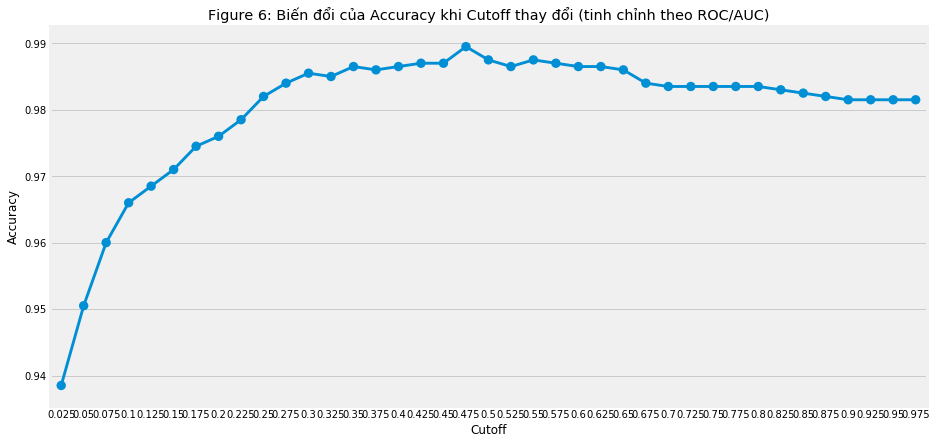

In [29]:
#============================================================================
#  Khảo sát sự biến đổi của Accuracy cho RF tinh chinh theo tiêu chí ROC/AUC
#============================================================================

pred_prob = best_rf_roc.predict_proba(X_test)

def calculate_accuracy(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int)
    accuracy = np.mean(pred_bg == y_test)
    return(accuracy)

cutoff = np.arange(0.025, 1, 0.025)

acc = []
for i in cutoff:
    acc_i = calculate_accuracy(cutoff=i)
    acc.append(acc_i)

plt.figure(figsize = (14, 7))
df_results_acc_by_roc = {"Cutoff": np.round(cutoff, 4), "Accuracy": acc}
sns.pointplot(x="Cutoff", y="Accuracy", scale = 0.4, data = df_results_acc_by_roc)
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")
plt.title("Figure 6: Biến đổi của Accuracy khi Cutoff thay đổi (tinh chỉnh theo ROC/AUC)")

Do có sự đánh đổi giữa các tiêu chí nên Accuracy sẽ có dạng hình chữ U ngược: Accuracy tăng theo cutoff và đến một ngưỡng nào đó thì bắt đầu giảm. 

# Ngưỡng tối ưu lợi nhuận cho mô hình Logistic

Logistic - một cách tiếp cận của thống kê truyền thống thường được sử dụng như "tiêu chuẩn" (hay base line) để so sánh và đánh giá. Chúng ta có thể khảo sát biến động lợi nhuận và Accuracy theo các ngưỡng. Chú ý rằng Logistic được coi là mô hình không có tham số tinh chỉnh: 

In [30]:
# Huấn luyện Logistic: 
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

# Sử dụng mô hình Logistic thực hiện dự báo PD: 
pred_prob = logmodel.predict_proba(X_test)

C:\Users\Zbook\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, 'Figure 7: Biến đổi của Profit khi Cutoff thay đổi (Mô hình Logistic)')

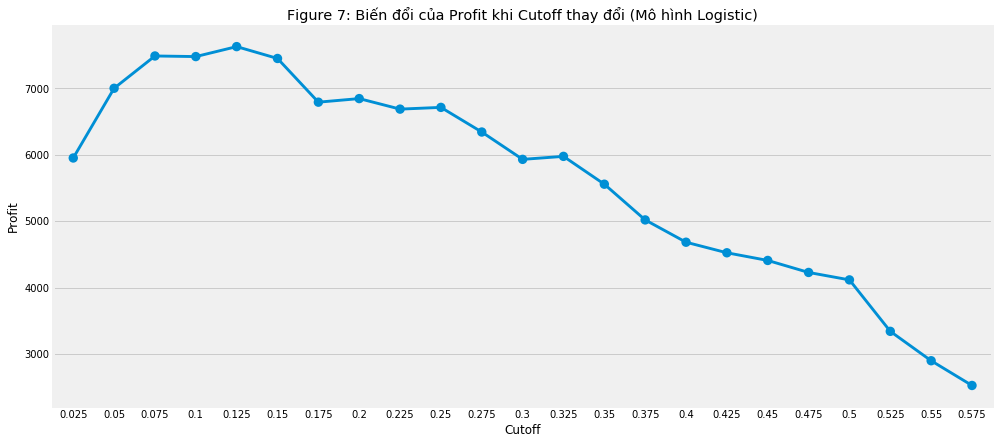

In [31]:
#==================================================================
# Khảo sát biến đổi của lợi nhuận khi cutoff thay đổi cho Logistic
#================================================================== 

cutoff = np.arange(0.025, 0.6, 0.025)

def profit_by_cutoff(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int) 
    gg = X_test[(y_test == 0) & (pred_bg == 0)]
    bg = X_test[(y_test == 1) & (pred_bg == 0)]
    profit = np.sum(0.10*gg[["Income"]]) - np.sum(bg[["Income"]])
    return(profit) 

profit = []
for i in cutoff:
    prof_i = profit_by_cutoff(cutoff=i)
    profit.append(prof_i)
    
plt.figure(figsize = (15, 7))
df_results_logit = {"Cutoff": np.round(cutoff, 4), "Profit": profit}
sns.pointplot(x="Cutoff", y="Profit", scale = 0.4, data = df_results_logit)
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.title("Figure 7: Biến đổi của Profit khi Cutoff thay đổi (Mô hình Logistic)")

Text(0.5, 1.0, 'Figure 8: Biến đổi của Accuracy khi Cutoff thay đổi (Mô hình Logistic)')

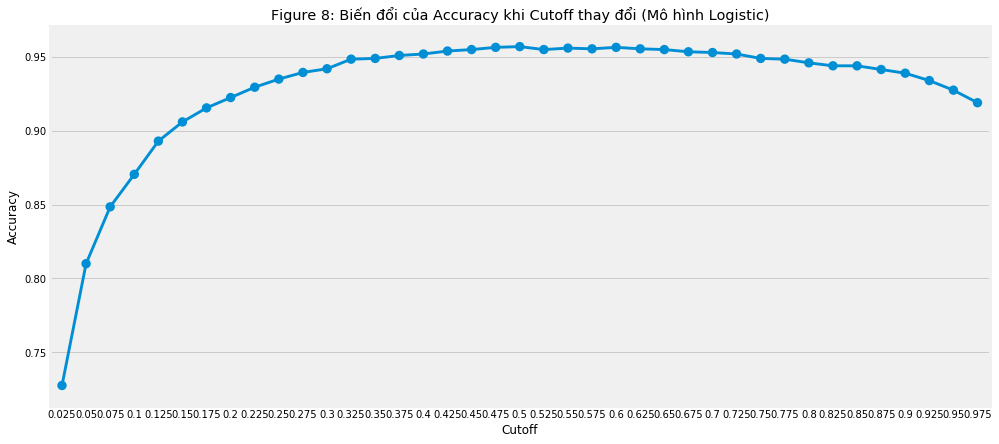

In [32]:
#==================================================================
# Khảo sát biến đổi của Accuracy khi cutoff thay đổi cho Logistic
#==================================================================

def calculate_accuracy(cutoff):
    pred_bg = (pred_prob[:, 1] >= cutoff).astype(int)
    accuracy = np.mean(pred_bg == y_test)
    return(accuracy)

cutoff = np.arange(0.025, 1, 0.025)

acc = []
for i in cutoff:
    acc_i = calculate_accuracy(cutoff=i)
    acc.append(acc_i)

plt.figure(figsize = (15, 7))
df_results_acc_logit = {"Cutoff": np.round(cutoff, 4), "Accuracy": acc}
sns.pointplot(x="Cutoff", y="Accuracy", scale = 0.4, data = df_results_acc_logit)
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")
plt.title("Figure 8: Biến đổi của Accuracy khi Cutoff thay đổi (Mô hình Logistic)")


# Kết luận

Dựa trên các kết quả thực nghiệm thu được với bộ số liệu UniversalBank.csv chúng ta thấy rằng với bài toán phân loại và xếp hạng hồ sơ xin vay thì tiêu chí phù hợp để tinh chỉnh và lựa chọn mô hình trước hết phải căn cứ vào mục tiêu kinh doanh của tổ chức. Nếu mục tiêu là "lợi nhuận là số một" thì có thể lựa chọn có thể sẽ là tinh chỉnh theo Accuracy, còn nếu mục tiêu là "lợi nhuận cao và ổn định" thì RF nên được tinh chỉnh theo Recall. Mặt khác do vấn đề Asymmetric Misclassifcation Costs thì một mô hình có Accuracy có thể lại là một mô hình tạo la lợi nhuận tệ nhất cho ngân hàng. 


# Tài liệu tham khảo

1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.

2. Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. New York: Springer.

3. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. O'Reilly Media, Inc.

4. Géron, A. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. O'Reilly Media, Inc.

5. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons.